# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

In [1]:
import sklearn # Проверка версии sklearn. Обновляем при необходимости
if sklearn.__version__[0] == '0':
    !pip install scikit-learn -U # После установки надо перезапустить ядро
sklearn.__version__ 

'1.5.1'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import notebook
import spacy
import re

try:
    import torch
except:
    !pip install torch
    import torch

try:
    import transformers
except:
    !pip install transformers
    import transformers

try:
    from ydata_profiling import ProfileReport
except:
    !pip install -U Pillow # Для решения ошибки с профайлером
    !pip install -U ydata-profiling
    from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

In [3]:
RANDOM_STATE = 42
SAMPLE_SIZE = 500

## Подготовка

Для начала загрузим данные и сразу-же с ними ознакомимся.

In [4]:
try:
    ds = pd.read_csv('/datasets/toxic_comments.csv', index_col='Unnamed: 0')
except:
    ds = pd.read_csv('datasets/toxic_comments.csv', index_col='Unnamed: 0')
#ProfileReport(ds)

Дизбаланс классов в целевом признаке, токсичных комментариев почти в 10 раз меньше, чем нетоксичных. Без стратификации здесь не обойтись. 

Так-же не обойтись и без фильтра стоп-слов, они встречаются в наших текстах чаще всех остальных.

In [5]:
ds = ds.sample(SAMPLE_SIZE, random_state=RANDOM_STATE).reset_index(drop=True)
ds['toxic'].value_counts()

toxic
0    894
1    106
Name: count, dtype: int64

In [6]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')  
model = transformers.BertModel.from_pretrained('bert-base-cased')

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [7]:
class ToxicFeatures(TransformerMixin, BaseEstimator):
    def __init__(self, max_len=512):
        self.max_len = max_len
    
    def fit(self, X, y): 
        # Обучение классу не требуется, скипаем
        return self
    
    def transform(self, X): 
        # Лемматизация
        spc = spacy.load('en_core_web_sm')
        lemmatized = X.apply(lambda x: ' '.join([token.lemma_ for token in spc(x)]))
        # Очистка от лишних символов
        regular = lemmatized.apply(lambda x: ' '.join((re.sub(r'[^a-zA-Z]', ' ', x)).split()))
        # Токенизация
        tokenized = regular.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=self.max_len, truncation=True))
        max_len = max(tokenized.apply(len))
        padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
        attention_mask = np.where(padded != 0, 1, 0)
        batch_size = 100
        embeddings = []
        for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
            batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
            attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
            
            with torch.no_grad(): # Для ускорения вычислений отключим градиенты
                batch_embeddings = model(batch, attention_mask=attention_mask_batch)
            
            embeddings.append(batch_embeddings[0][:,0,:].numpy())
        return np.concatenate(embeddings)

In [8]:
tf = ToxicFeatures()

X_train, X_test, y_train, y_test = train_test_split(
    tf.transform(ds['text']), 
    ds['toxic'], 
    stratify=ds['toxic'], 
    test_size=0.2, 
    random_state=RANDOM_STATE)

  0%|          | 0/10 [00:00<?, ?it/s]

## Обучение

In [9]:
lr_params = {
    'C':range(1, 5),
    'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
}

lr_cv = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE),
    param_grid=lr_params,
    n_jobs=-1,
    scoring='f1',
    cv=4
)
lr_cv.fit(X_train, y_train)
lr_cv.best_score_

0.5368003341687553

In [10]:
rd_params = {
    'alpha':[0.2, 0.4, 0.6, 0.8, 1],
    'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg']
}

rd_cv = GridSearchCV(
    RidgeClassifier(),
    param_grid=rd_params,
    n_jobs=-1,
    scoring='f1',
    cv=4
)
rd_cv.fit(X_train, y_train)
rd_cv.best_score_

0.47589252852410746

In [11]:
kn_params = {
    'n_neighbors':range(1, 10)
}

kn_cv = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=kn_params,
    n_jobs=-1,
    scoring='f1',
    cv=4
)
kn_cv.fit(X_train, y_train)
kn_cv.best_score_

0.4897482303732304

## Выводы

In [12]:
def res_pres(true, pred, name):
    print(name)
    print('f1:', f1_score(y_test, pred).round(3))
    ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot(cmap=plt.cm.Purples)

Модель-болванка
f1: 0.19


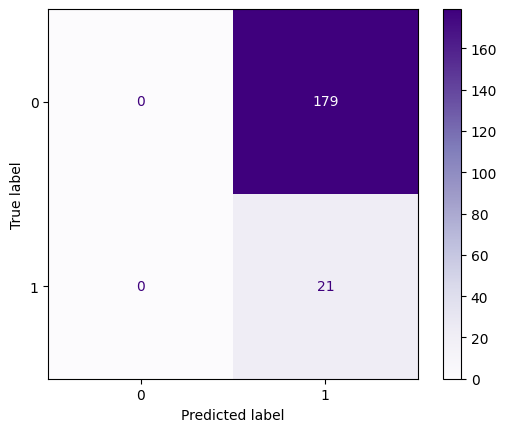

In [13]:
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(X_train, y_train)
res_pres(y_test, dummy.predict(X_test), 'Модель-болванка')

Логистистическая регрессия
f1: 0.483


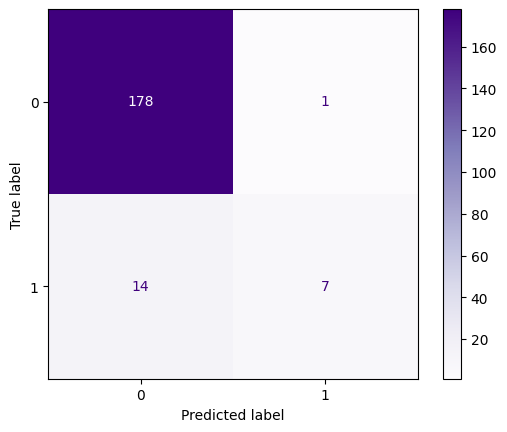

In [14]:
lr_cv.best_estimator_.fit(X_train, y_train)
res_pres(y_test, lr_cv.best_estimator_.predict(X_test), 'Логистистическая регрессия')

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны